# Data Analysis Report: What Globalisation Brings to a Country

## Introduction 

With death toll's voice of the former Soviet Union and the cold war ends, globalization influences the world rapidly. In TV shows, we can see human right NGO from the United States gives Iraqi war refugee kids' backpack written with Chinese word and Japanese cartoon character Ultraman, and in Tibet, for those Tibetan shepherds, no matter they are old or young, their favorite drink is no longer jasrubma but Coca Cola. But in recent years, From Trump begin his presidency to Brazilian new president announced he would bring the country back to the authoritarian era, more and more people begin to doubt that globalization is just a fantastic love story. In this report, we are going to use the data from the World Bank, to find what kind of countries are most influenced by globalization.

In [5]:
import os
import urllib.request
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import functools
import numpy as np
import fileinput, sys

In [6]:
pd.options.display.float_format = '{:20,.2f}'.format

def json_clean(filename):
    del filename[0]
    filename = filename[0]
    return filename

def utf8(filename:list,empty_filename:list):
    for each in filename:
        new_type = each.read().decode("utf-8")
        empty_filename.append(new_type)
        
def remove_redundant(filename:list,column_name:str,empty_filename:list):
    for each in filename:
        id_ = each.get('country').get('id')
        value = each.get('value')
        final = {'id': id_, '%s'%column_name: value}
        empty_filename.append(final)
        
def csv_generator(csv_name:str,column_name:str,filename:list):
    with open(csv_name, "w", newline = "") as file:
        title = ["id","%s"%column_name]
        write_csv = csv.DictWriter(file,title,delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        write_csv.writeheader()
        write_csv.writerows(filename)

def csv_merger(name:str,merged_csv:list):
    dfs = [pd.read_csv(f"%s{i}.csv"%name) for i in range(1, 5)]
    df = functools.reduce(lambda df1, df2: pd.merge(left=df1, right=df2, on=["id"], how="inner"), dfs)
    df.columns=merged_csv
    df.to_csv('%s.csv'%name,index=False)
    
def all_set():
    with open('global.csv', 'r') as fin, open('globals.csv', 'w', newline='') as fout:
        reader = csv.reader(fin, skipinitialspace=True)
        writer = csv.writer(fout, delimiter=',')
        writer.writerow(next(reader))
        for i in reader:
            if i[1] != 'Aggregates':
                writer.writerow(i)
    
    temp = open('globals.csv')
    Ids = [row[0:2] for row in temp]
    #whitelist of country/region

    def sets(original,edited):
        with open('%s.csv'%original, 'r') as fin, open('%s.csv'%edited, 'w', newline='') as fout:
            reader = csv.reader(fin, skipinitialspace=True)
            writer = csv.writer(fout, delimiter=',')
            writer.writerow(next(reader))
            for i in reader:
                if i[0] in Ids[1:]:
                    writer.writerow(i)
    
    sets('fdi','fdis')
    sets('fdi1','fdi1987')
    sets('fdi2','fdi1997')
    sets('fdi3','fdi2007')
    sets('fdi4','fdi2017')
    sets('gdp','gdps')
    sets('gdp1','gdp1987')
    sets('gdp2','gdp1997')
    sets('gdp3','gdp2007')
    sets('gdp4','gdp2017')
    
    removed = ['global.csv','fdi.csv','fdi1.csv','fdi2.csv','fdi3.csv','fdi4.csv','gdp.csv','gdp1.csv','gdp2.csv','gdp3.csv','gdp4.csv']
    for each in removed:
        os.remove(each)
        
def piechart(value,label):
    figureObject,figValue = plt.subplots()
    try:
        colours = ["lightblue","lightgreen","lavender","tan","plum"]
        figValue.pie(value,
        labels = label,
        startangle = 90,
        colors = colours)
    except:
        colours = ["lightblue","lightgreen","lavender","tan","plum",'mistyrose']
        figValue.pie(value,
        labels = label,
        startangle = 90,
        colors = colours)
    figValue.axis("equal")
    plt.show()

def top20s(filename,year):
    top20 =filename.sort_values('fdi',ascending = False).groupby('fdi').head(2)
    top20 = top20[['fdi','id']].head(21)

    top20code = top20['id']
    top20code = top20code.to_string(index=False)
    top20code = top20code.split()
    
    temp = '|'.join(top20code)

    top20name = global_data[global_data['id'].str.contains(temp, na=False)][['id','name']]
    top20region = global_data[global_data['id'].str.contains(temp, na=False)][['id','region']]
    top20gdp = gdp[gdp['id'].str.contains(temp, na=False)][['id','gdp%s'%year]]

    def cats(dataframe):
        dataframe['id'] = pd.Categorical(
        dataframe['id'],
        categories = top20code,
        ordered = True)
        dataframe.sort_values('id',inplace = True)

    cats(top20name)
    cats(top20region)
    cats(top20gdp)

    lists=[top20gdp,top20region,top20name]
    df = reduce(lambda df1, df2: pd.merge(left=df1, right=df2, on=["id"], how="inner"), lists)
    df['id'] = pd.Categorical(df.id, categories = top20code, ordered = True)
    df.sort_values(by='id')
    raw=df.sort_values(by='id')
    return raw

def barchart(raw,year):
    avg = gdp.mean().head(1)
    average = avg[0]

    gdplist=raw['gdp'+str(year)]
    gdplist=gdplist.to_string(index=False)
    gdplist=gdplist.split()
    gdplist=[i.replace(',', '') for i in gdplist]
    gdplist=[float(i) for i in gdplist]
    gdplist=tuple(gdplist)

    countrylist=raw['name']
    countrylist=countrylist.to_string(index=False)
    countrylist=countrylist.split('\n')
    countrylist=tuple(countrylist)

    pos = np.arange(len(countrylist))

    temp=[]

    for i in gdplist:
        if i<average:
            temp.append('red')
        else:
            temp.append('lightblue')

    temp=tuple(temp)
        
    plt.figure(figsize=(20,4))
    plt.bar(pos,gdplist,color=temp)
    plt.xticks(pos, countrylist,rotation=40, ha="right")
    plt.xlabel('Country', fontsize=16)
    plt.ylabel('GDP per capita', fontsize=16)
    plt.show()
    
def get_details(raw_data):
    detail = raw_data['region'].value_counts()
    print(detail)
    data = []
    for each in range(len(detail)):
        data.append(detail[each])
    return data

In [7]:
url = "http://api.worldbank.org/v2/country/?per_page=304&format=json"
response = urllib.request.urlopen(url)
raw_json = response.read().decode("utf-8")
data = json.loads(raw_json)

data = json_clean(data)
cleaned_data = []

for each in data:
    countryid = each.get('iso2Code')
    income = each.get('incomeLevel').get('value')
    name = each.get('name')
    region = each.get('region').get('value')
    cleaned_data.append({'id':countryid, 'incomeLevel': income, 'name': name, 'region': region})
    
with open("global.csv","w",newline = "") as f:
    title = "id,incomeLevel,name,region".split(",")
    cw = csv.DictWriter(f,title,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    cw.writeheader()
    cw.writerows(cleaned_data)

In [8]:
fdi1987 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/BX.KLT.DINV.CD.WD?date=1987&per_page=264&format=json")
fdi1997 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/BX.KLT.DINV.CD.WD?date=1997&per_page=264&format=json")
fdi2007 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/BX.KLT.DINV.CD.WD?date=2007&per_page=264&format=json")
fdi2017 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/BX.KLT.DINV.CD.WD?date=2017&per_page=264&format=json")

old_fdi_list = [fdi1987,fdi1997,fdi2007,fdi2017]
new_fdi_list = []
utf8(old_fdi_list, new_fdi_list)

fdi1987 = []
fdi1997 = []
fdi2007 = []
fdi2017 = []
remove_redundant(json_clean(json.loads(new_fdi_list[0])),'fdi',fdi1987)
remove_redundant(json_clean(json.loads(new_fdi_list[1])),'fdi',fdi1997)
remove_redundant(json_clean(json.loads(new_fdi_list[2])),'fdi',fdi2007)
remove_redundant(json_clean(json.loads(new_fdi_list[3])),'fdi',fdi2017)

csv_generator('fdi1.csv','fdi',fdi1987)
csv_generator('fdi2.csv','fdi',fdi1997)
csv_generator('fdi3.csv','fdi',fdi2007)
csv_generator('fdi4.csv','fdi',fdi2017)

merge = ['id','fdi1987','fdi1997','fdi2007','fdi2017']

csv_merger("fdi",merge)

In [9]:
gdp1987 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?date=1987&per_page=264&format=json")
gdp1997 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?date=1997&per_page=264&format=json")
gdp2007 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?date=2007&per_page=264&format=json")
gdp2017 = urllib.request.urlopen("https://api.worldbank.org/v2/country/all/indicator/NY.GDP.PCAP.CD?date=2017&per_page=264&format=json")

old_gdp_list = [gdp1987,gdp1997,gdp2007,gdp2017]
new_gdp_list = []
utf8(old_gdp_list,new_gdp_list)

gdp1987 = []
gdp1997 = []
gdp2007 = []
gdp2017 = []
remove_redundant(json_clean(json.loads(new_gdp_list[0])),'gdp_per_capita',gdp1987)
remove_redundant(json_clean(json.loads(new_gdp_list[1])),'gdp_per_capita',gdp1997)
remove_redundant(json_clean(json.loads(new_gdp_list[2])),'gdp_per_capita',gdp2007)
remove_redundant(json_clean(json.loads(new_gdp_list[3])),'gdp_per_capita',gdp2017)

csv_generator('gdp1.csv','gdp_per_capita',gdp1987)
csv_generator('gdp2.csv','gdp_per_capita',gdp1997)
csv_generator('gdp3.csv','gdp_per_capita',gdp2007)
csv_generator('gdp4.csv','gdp_per_capita',gdp2017)

merge = ['id','gdp1987','gdp1997','gdp2007','gdp2017']

csv_merger('gdp',merge)

In [10]:
all_set()

In [11]:
global_data = pd.read_csv('globals.csv')
fdi = pd.read_csv('fdis.csv')
gdp = pd.read_csv('gdps.csv')

Global income level sample number:218

Dataset structure:
   id          incomeLevel         name                      region
0  AW          High income        Aruba  Latin America & Caribbean 
1  AF           Low income  Afghanistan                  South Asia
2  AO  Lower middle income       Angola         Sub-Saharan Africa 
3  AL  Upper middle income      Albania       Europe & Central Asia
4  AD          High income      Andorra       Europe & Central Asia

Countries in each region:
Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           38
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: region, dtype: int64

Income level details in each region:
region                      incomeLevel        
East Asia & Pacific         High income            14
                            Low income              1
                            Lower middle income    13
 

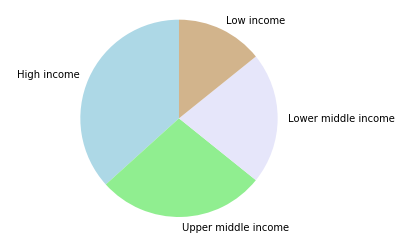

In [12]:
print("Global income level sample number:"+str(len(global_data)))
print()
print('Dataset structure:')
print(global_data.head())
region = global_data[['region','id']]
print()
print("Countries in each region:")
print(region['region'].value_counts())
print()
income_level = global_data[['region','incomeLevel']]
print("Income level details in each region:")
print(income_level.groupby(['region','incomeLevel'])['region'].count())
print()
income_level_graph = global_data[['incomeLevel','id']]
income_level_show = income_level_graph['incomeLevel'].value_counts()
income_data = [income_level_show[0],income_level_show[1],income_level_show[2],income_level_show[3]]
label_name = 'High income','Upper middle income','Lower middle income','Low income'
print("Total number in each income level:")
print(income_level_show)
piechart(income_data,label_name)

In [13]:
print('FDI sample number:'+str(len(fdi)))
print()
print(fdi.describe())

FDI sample number:216

                   fdi1987              fdi1997              fdi2007  \
count               146.00               185.00               200.00   
mean        873,373,115.27     2,480,699,355.84    15,512,890,938.22   
std       5,095,042,957.13     9,277,243,709.78    62,009,882,046.33   
min      -1,173,333,333.33      -311,296,101.19   -29,679,425,810.05   
25%           3,156,271.69        22,944,444.44       139,281,138.43   
50%          19,398,561.15       166,800,000.00       857,600,000.00   
75%         118,231,498.72     1,215,000,000.00     6,145,303,553.62   
max      58,471,000,000.00   105,590,000,000.00   734,010,312,477.36   

                   fdi2017  
count               197.00  
mean     10,565,551,713.19  
std      39,487,196,900.36  
min     -39,482,279,939.49  
25%         124,465,535.70  
50%         865,903,085.19  
75%       4,017,159,564.65  
max     354,828,000,000.00  


In [14]:
print("GDP per capita sample number:"+str(len(gdp)))
print()
print(gdp.describe())

GDP per capita sample number:216

                   gdp1987              gdp1997              gdp2007  \
count               159.00               189.00               205.00   
mean              5,294.14             7,852.18            15,494.69   
std               8,381.16            12,689.58            24,208.42   
min                 145.32               138.97               172.50   
25%                 634.67               669.40             1,327.96   
50%               1,571.30             2,195.79             4,703.21   
75%               6,627.73             9,505.67            18,373.65   
max              63,051.82            90,798.66           169,961.38   

                   gdp2017  
count               199.00  
mean             15,432.80  
std              21,902.33  
min                 293.01  
25%               2,051.51  
50%               6,120.51  
75%              19,259.05  
max             166,726.05  


In [15]:
fdi1987 = pd.read_csv('fdi1987.csv')
fdi1997 = pd.read_csv('fdi1997.csv')
fdi2007 = pd.read_csv('fdi2007.csv')
fdi2017 = pd.read_csv('fdi2017.csv')

In [16]:
year1987 = top20s(fdi1987,'1987')
year1997 = top20s(fdi1997,'1997')
year2007 = top20s(fdi2007,'2007')
year2017 = top20s(fdi2017,'2017')

The relationship between FDI and GDP per capita(1987) in FDI top 20 countries.

    id              gdp1987                      region              name
0   US            20,038.94               North America     United States
1   GB            13,118.59       Europe & Central Asia    United Kingdom
2   CA            16,308.97               North America            Canada
3   AU            11,624.46         East Asia & Pacific         Australia
4   FR            16,302.44       Europe & Central Asia            France
5   ES             8,217.23       Europe & Central Asia             Spain
6   IT            14,187.77       Europe & Central Asia             Italy
7   NL            16,709.56       Europe & Central Asia       Netherlands
8   SG             7,539.03         East Asia & Pacific         Singapore
9   CH            29,558.90       Europe & Central Asia       Switzerland
10  CN               251.81         East Asia & Pacific             China
11  DE            16,614.41     

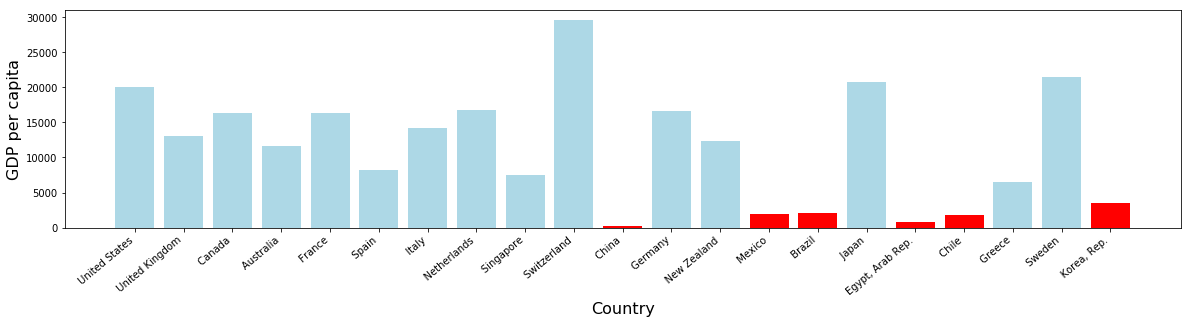

Geograpic details of FDI top 20 countries:

Europe & Central Asia         9
East Asia & Pacific           6
Latin America & Caribbean     3
North America                 2
Middle East & North Africa    1
Name: region, dtype: int64


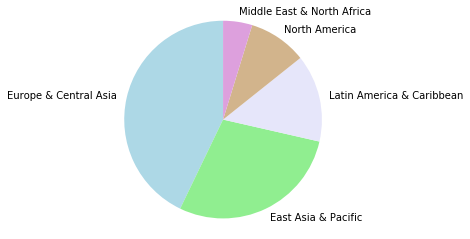

In [17]:
print("The relationship between FDI and GDP per capita(1987) in FDI top 20 countries.")
print()
print(year1987)
barchart(year1987,1987)
print("Geograpic details of FDI top 20 countries:")
print()
temp = get_details(year1987)
region_1987=[temp[0],temp[1],temp[2],temp[3],temp[4]]
label_1987 = 'Europe & Central Asia','East Asia & Pacific','Latin America & Caribbean', 'North America','Middle East & North Africa'
piechart(region_1987,label_1987)

The relationship between FDI and GDP per capita(1997) in FDI top 20 countries.

    id              gdp1997                      region                name
0   US            31,459.14               North America       United States
1   CN               781.74         East Asia & Pacific               China
2   GB            26,641.02       Europe & Central Asia      United Kingdom
3   FR            24,228.94       Europe & Central Asia              France
4   BR             5,282.01  Latin America & Caribbean               Brazil
5   SG            26,375.97         East Asia & Pacific           Singapore
6   MX             5,289.17  Latin America & Caribbean               Mexico
7   DE            27,045.72       Europe & Central Asia             Germany
8   CA            21,829.23               North America              Canada
9   NL            26,700.54       Europe & Central Asia         Netherlands
10  SE            29,938.02       Europe & Central Asia              Sweden
11  AR  

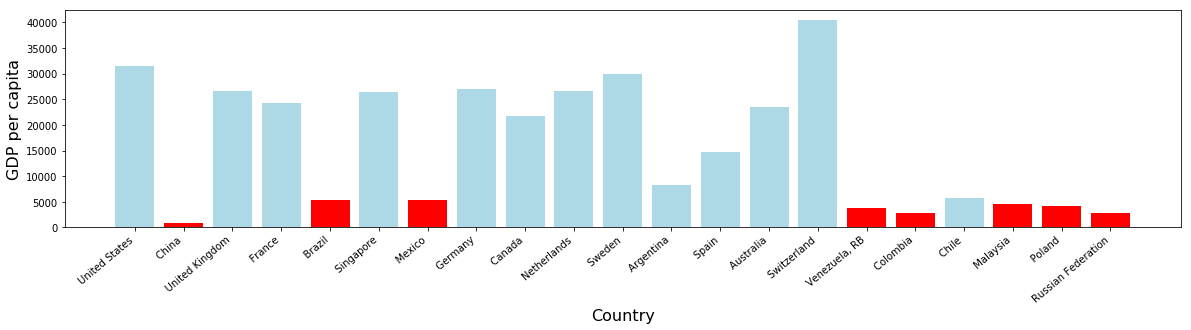

Geograpic details of FDI top 20 countries:

Europe & Central Asia         9
Latin America & Caribbean     6
East Asia & Pacific           4
North America                 2
Name: region, dtype: int64


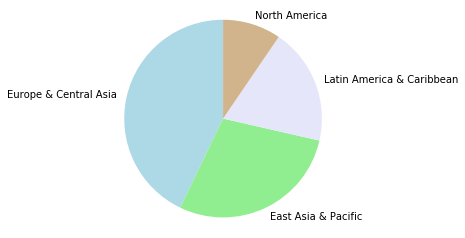

In [18]:
print("The relationship between FDI and GDP per capita(1997) in FDI top 20 countries.")
print()
print(year1997)
barchart(year1997,1997)
print("Geograpic details of FDI top 20 countries:")
print()
temp = get_details(year1997)
region_1997=[temp[0],temp[1],temp[2],temp[3]]
label_1997 = 'Europe & Central Asia','East Asia & Pacific','Latin America & Caribbean', 'North America'
piechart(region_1997,label_1997)

The relationship between FDI and GDP per capita(2007) in FDI top 20 countries.

    id              gdp2007                      region  \
0   NL            51,733.44       Europe & Central Asia   
1   US            47,975.97               North America   
2   GB            50,293.44       Europe & Central Asia   
3   CN             2,693.97         East Asia & Pacific   
4   CA            44,543.04               North America   
5   BE            44,403.77       Europe & Central Asia   
6   FR            41,508.43       Europe & Central Asia   
7   ES            32,709.40       Europe & Central Asia   
8   HU            13,907.50       Europe & Central Asia   
9   AT            46,855.77       Europe & Central Asia   
10  IT            37,698.79       Europe & Central Asia   
11  HK            30,594.02         East Asia & Pacific   
12  IE            61,359.74       Europe & Central Asia   
13  RU             9,101.26       Europe & Central Asia   
14  DE            41,814.82       E

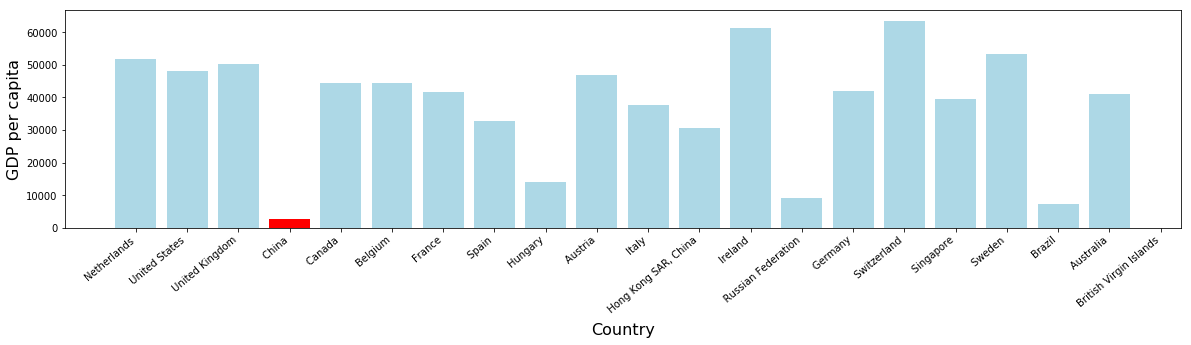

Geograpic details of FDI top 20 countries:

Europe & Central Asia         13
East Asia & Pacific            4
Latin America & Caribbean      2
North America                  2
Name: region, dtype: int64


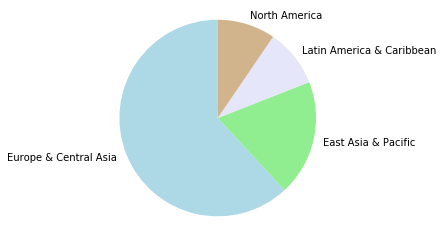

In [19]:
print("The relationship between FDI and GDP per capita(2007) in FDI top 20 countries.")
print()
print(year2007)
barchart(year2007,2007)
print("Geograpic details of FDI top 20 countries:")
print()
temp = get_details(year2007)
region_2007=[temp[0],temp[1],temp[2],temp[3]]
label_2007 = 'Europe & Central Asia','East Asia & Pacific','Latin America & Caribbean', 'North America'
piechart(region_2007,label_2007)

The relationship between FDI and GDP per capita(2017) in FDI top 20 countries.

    id              gdp2017                      region  \
0   US            59,927.93               North America   
1   NL            48,482.77       Europe & Central Asia   
2   CN             8,759.04         East Asia & Pacific   
3   HK            46,220.50         East Asia & Pacific   
4   GB            39,932.06       Europe & Central Asia   
5   SG            60,297.79         East Asia & Pacific   
6   DE            44,681.08       Europe & Central Asia   
7   BR             9,880.95  Latin America & Caribbean    
8   CH            80,333.44       Europe & Central Asia   
9   FR            38,679.13       Europe & Central Asia   
10  AU            54,093.60         East Asia & Pacific   
11  IN             1,981.50                  South Asia   
12  VG                  nan  Latin America & Caribbean    
13  KY            56,334.21  Latin America & Caribbean    
14  MX             9,281.10  Latin 

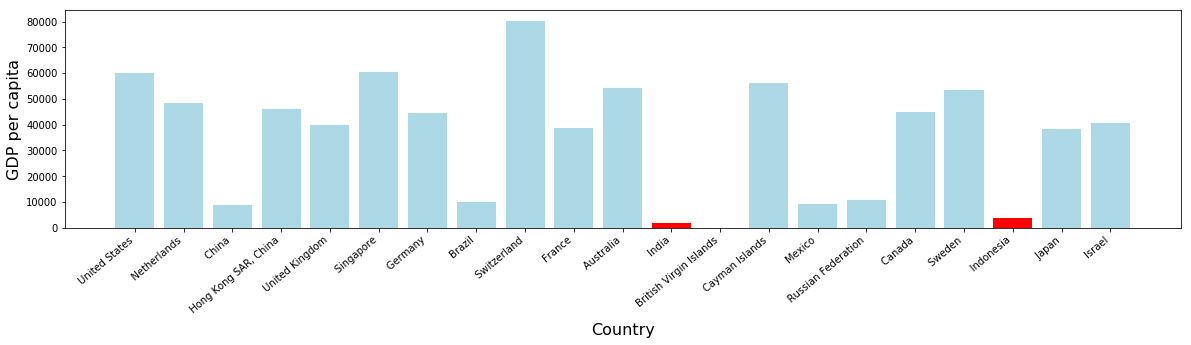

Geograpic details of FDI top 20 countries:

Europe & Central Asia         7
East Asia & Pacific           6
Latin America & Caribbean     4
North America                 2
South Asia                    1
Middle East & North Africa    1
Name: region, dtype: int64


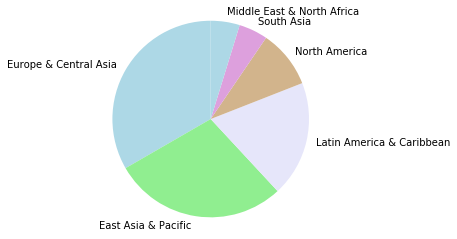

In [20]:
print("The relationship between FDI and GDP per capita(2017) in FDI top 20 countries.")
print()
print(year2017)
barchart(year2017,2017)
print("Geograpic details of FDI top 20 countries:")
print()
temp = get_details(year2017)
region_2017=[temp[0],temp[1],temp[2],temp[3],temp[4],temp[5]]
label_2017 = 'Europe & Central Asia','East Asia & Pacific ','Latin America & Caribbean', 'North America','South Asia','Middle East & North Africa'
piechart(region_2017,label_2017)

## Summary 

From the above, it is obvious that globalisation really helps global development. But, in our statistics, most of the foreign trade happened between developed countries with high GDP per capita, only a few countries will have the opportunity to be invested. Even for those developing country are being invested, they have very few opportunity to become rich.

Another point worth to attention is, from 2007 to 2017, tax haven countries such as Cayman and British Virgin have become more and more popular. Which means the rich people are transferring their profit to their offshore account to avoid tax, which reduces government revenues and reduce the quality of public service facilities. It may cause grassroots people to attract by populist and show their negative attitude to globalization.

Finally, from the result of 2017, we can imagine in the future, Indonesia and India will have opportunity to copy economic miracle in China, and Israel, Ph.D. holders proportion of the population ranked first in the world are becoming famous, maybe related to the development of biochemistry, robot industry, and AI.

## Limitation 

In the view of coding, we should try to use more visualisation format. For example, when we are analysing the region of countries, we can use a map instead of the pie chart, which helps us find the geographical rules of foreign investor's interest. And also, we can separate the dataset to a different group, and find what kind of country in each income level are popular to foreign investors. Last but not least, based on limitation above, we can also collect more data such as female secondary school enroll percentage or economic freedom index to find the high FDI country, especially those lower middle income or low-income countries' characteristics, which helps us know how to attract foreign capital, especially for those poor countries.